In [1]:
import napari
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage import measure
from arcos4py.tools import track_events_image
from napari_timestamper import render_as_rgb, save_image_stack
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from scipy import ndimage

import numpy as np
from scipy import ndimage
from skimage.morphology import binary_opening, square
from matplotlib_scalebar.scalebar import ScaleBar

from napari_convpaint import conv_paint_utils
import numpy as np
import napari

# set plot parameters for publication quality
from matplotlib import rcParams
import nd2
plt.rcParams['svg.fonttype'] = 'none'
rcParams['font.family'] = 'Arial'


ModuleNotFoundError: No module named 'napari_convpaint'

In [8]:
with nd2.ND2File(r"\\izbkingston.izb.unibe.ch\imaging.data\bgraedel\Podosome_Project\20210626_EB1\EB1eGFP_LAmCherry_PDGF002.nd2") as f:
    m = f.metadata
    mu = f.unstructured_metadata()
    arr = f.asarray()

In [3]:
from typing import Tuple, Optional, Callable, Union, Literal
from scipy.optimize import curve_fit

ExpFuncType = Callable[[np.ndarray, float, float], np.ndarray]

# Function type for _bi_exp
BiExpFuncType = Callable[[np.ndarray, float, float, float, float], np.ndarray]

# Union type for both function types
FuncType = Union[ExpFuncType, BiExpFuncType]


def _exp(x: np.ndarray, a: float, b: float) -> np.ndarray:
    return a * np.exp(-b * x)


def _bi_exp(x: np.ndarray, a: float, b: float, c: float, d: float) -> np.ndarray:
    return (a * np.exp(-b * x)) + (c * np.exp(-d * x))


def _exponential_correct(
    images: np.ndarray,
    contrast_limits: Optional[Tuple[int, int]] = None,
    method: Literal["mono", "bi"] = "mono",
) -> np.ndarray:
    """Corrects photobleaching in a 3D or 4D image stack using an exponential curve.

    Adapted from:
    https://github.com/marx-alex/napari-bleach-correct/blob/main/src/napari_bleach_correct/modules/exponential.py.
    """
    dtype = images.dtype
    if contrast_limits is None:
        contrast_limits = (np.min(images), np.max(images))
    assert (
        3 <= len(images.shape) <= 4
    ), f"Expected 3d or 4d image stack, instead got {len(images.shape)} dimensions"

    avail_methods = ["mono", "bi"]
    func: FuncType
    if method == "mono":
        func = _exp
    elif method == "bi":
        func = _bi_exp
    else:
        raise NotImplementedError(
            f"method must be one of {avail_methods}, instead got {method}"
        )

    axes = tuple(range(len(images.shape)))
    I_mean = np.mean(images, axis=axes[1:])
    x_data = np.arange(images.shape[0])

    with np.errstate(over="ignore"):
        try:
            popt, _ = curve_fit(func, x_data, I_mean)
            f_ = np.vectorize(func)(x_data, *popt)
        except (ValueError, RuntimeError, Warning):
            f_ = np.ones(x_data.shape)

    residuals = I_mean - f_
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((I_mean - np.mean(I_mean)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"R^2: {r_squared}")

    f = f_ / np.max(f_)
    if len(images.shape) == 3:
        f = f.reshape(-1, 1, 1)
    else:
        f = f.reshape(-1, 1, 1, 1)
    images = images / f

    images[images < contrast_limits[0]] = contrast_limits[0]
    images[images > contrast_limits[1]] = contrast_limits[1]
    return images.astype(dtype)


In [4]:
lifeact = io.imread('podosomes_high_t.tif')

In [5]:
lifeact.shape

(396, 290, 274)

In [19]:
lifeact_bl = _exponential_correct(lifeact)

R^2: 0.9965979632582853


In [20]:
viewer = napari.Viewer()

In [21]:
viewer.add_image(lifeact_bl, name='lifeact', colormap='magma', blending='additive')

<Image layer 'lifeact' at 0x2a510818f10>

In [ ]:
viewer.window.add_plugin_dock_widget('napari-convpaint')

In [22]:
# load the joblib file 
random_forest, param = conv_paint_utils.load_trained_classifier(r'convpaint_model_3.joblib')

# create the model from the loaded parameters
model = conv_paint_utils.Hookmodel(model_name= param.model_name,param=param)
all_seg = []

if param.normalize:
    lifeact_bl_mean, lifeact_bl_std = conv_paint_utils.compute_image_stats(lifeact_bl)
    lifeact_bl_norm = conv_paint_utils.normalize_image(lifeact_bl, lifeact_bl_mean, lifeact_bl_std)

seg = np.zeros_like(lifeact_bl)

for z in range(lifeact_bl.shape[0]):
    prediction = conv_paint_utils.predict_image(lifeact_bl_norm[z], model, random_forest,
                                                scalings=param.scalings,
                                                order=param.order,
                                                use_min_features=param.use_min_features,
                                                image_downsample=param.image_downsample,)
    seg[z] = prediction
all_seg.append(seg)

# segment using convapint

In [26]:
viewer = napari.Viewer()
viewer.add_image(lifeact_bl, name='raw', colormap='magma', blending='translucent_no_depth')
viewer.add_labels(np.stack(all_seg), name='seg')

<Labels layer 'seg' at 0x2a516c15110>

In [56]:
# get binary mask from the model
# seg = viewer.layers['segmentation'].data
binary_mask = np.where(seg == 2, 1, 0)

c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


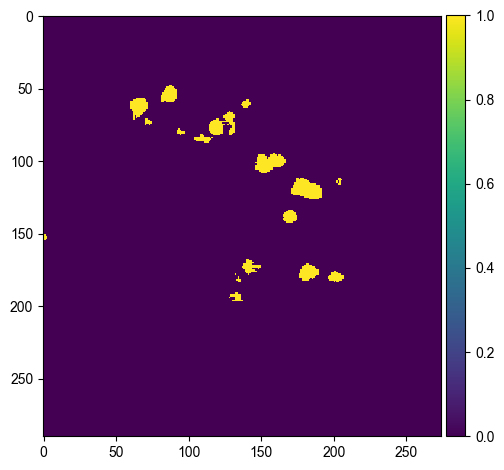

In [57]:
io.imshow(binary_mask[0])

In [55]:
binary_mask.shape

(1, 396, 290, 274)

In [67]:
all_events = track_events_image(binary_mask, eps=1.5, min_clustersize=5, n_prev=5)

100%|██████████| 396/396 [00:06<00:00, 57.34it/s]


In [46]:
all_events.shape

(396, 290, 274)

In [70]:
from skimage.filters import rank
all_events_filtered = rank.majority(all_events, footprint=np.ones((2, 3, 3)))

In [71]:
viewer = napari.Viewer()
viewer.add_image(np.asanyarray(lifeact_bl), name='lifeact', colormap='gray_r', blending='additive')
viewer.add_labels(np.asanyarray(all_events_filtered), name='filtered_events')
# viewer.add_labels(np.asanyarray(all_events), name='events')


<Labels layer 'filtered_events' at 0x2a5943a7850>

In [72]:
io.imsave('filtered_events.tif', all_events_filtered.astype(np.uint16))

C:\Users\benig\AppData\Local\Temp\ipykernel_15496\2430365880.py:1: UserWarning: filtered_events.tif is a low contrast image
  io.imsave('filtered_events.tif', all_events_filtered.astype(np.uint16))


In [73]:
# filter events so only first 10 frames are shown per event

from skimage.measure import regionprops_table

all_df = []
for idx, i in enumerate(all_events_filtered):
    props = regionprops_table(i, properties=('label', 'bbox', 'centroid'))
    df = pd.DataFrame(props)
    df['frame'] = idx
    all_df.append(df)



all_df = pd.concat(all_df)
all_df = all_df.rename(columns={'label': 'event_id', 'centroid-0': 'y', 'centroid-1': 'x'})


all_df_first = all_df.groupby('event_id').first().reset_index()
all_df_last = all_df.groupby('event_id').last().reset_index()


In [74]:
# add points to the viewer where new events are detected
viewer = napari.Viewer()
viewer.add_image(np.asanyarray(lifeact_bl), name='lifeact', colormap='gray_r', blending='additive')
viewer.add_labels(np.asanyarray(all_events_filtered), name='filtered_events')

viewer.add_points(all_df_first[['frame','y', 'x']], size=5, face_color='red', name='start_points', shading='spherical')
viewer.add_points(all_df_last[['frame','y', 'x']], size=5, face_color='blue', name='end_points', shading='spherical')

<Points layer 'end_points' at 0x2a63fa82010>

In [78]:
viewer = napari.current_viewer()
viewer.layers[0].bounding_box.visible = True
viewer.layers[0].bounding_box.line_color = 'gray'
viewer.layers[0].bounding_box.points = False
viewer.layers[0].bounding_box.line_thickness = 10

In [94]:
# add points to the viewer where new events are detected
viewer = napari.Viewer()
viewer.add_image(np.asanyarray(lifeact_bl), name='lifeact', colormap='gray_r', blending='additive')
viewer.add_labels(np.asanyarray(all_events_filtered), name='filtered_events')

<Labels layer 'filtered_events' at 0x2a48c46a050>

In [100]:
samples = np.linspace(0, 360, 3, dtype=int)

rgb_events = []
rbg_lifeact = []
viewer.layers['lifeact'].visible = True
viewer.layers['filtered_events'].visible = True
for img in samples:
    viewer.dims.set_current_step(0, img)
    rgb_events.append(render_as_rgb(viewer, upsample_factor=1))

viewer.layers['filtered_events'].visible = False

for img in samples:
    viewer.dims.set_current_step(0, img)
    rbg_lifeact.append(render_as_rgb(viewer, upsample_factor=1))

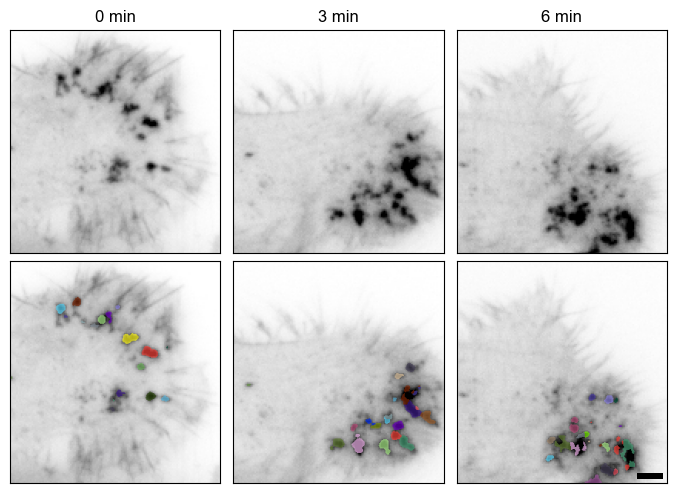

In [102]:
plt.rcParams['svg.fonttype'] = 'none'
# set font to arial
plt.rcParams['font.sans-serif'] = "Arial"


fig, ax = plt.subplots(2,3, figsize=(7,5))

for idx, val in enumerate(samples):
    ax[0, idx].imshow(rbg_lifeact[idx])
    ax[0, idx].set_xticks([])
    ax[0, idx].set_yticks([])
    # in minutes
    ax[0, idx].set_title(f'{val*1/60:.0f} min')

for idx, val in enumerate(samples):
    ax[1, idx].imshow(rgb_events[idx])
    ax[1, idx].set_xticks([])
    ax[1, idx].set_yticks([])
    if val == samples[-1]:
        scalebar = ScaleBar(0.15, "um", length_fraction=0.2, location='lower right', scale_loc="none", box_alpha=0, width_fraction=0.025)
        ax[1, idx].add_artist(scalebar)

plt.tight_layout(h_pad=1, w_pad=-0)
plt.savefig('plots/pannels.svg', dpi=600)
# scalebar = 5 um

In [86]:
from napari_timestamper import render_as_rgb
# make crop of single event and follow it over time with high temporal resolution

# get the event id
event_id = 15

# get the frames of the event
event_frames = np.where(all_events_filtered == event_id)

# get the first frame of the event
first_frame = event_frames[0][0]

# get bounding box of the event
bbox = ndimage.find_objects(all_events_filtered == event_id)[0]
# add 10 pixels to the bounding box
bbox = tuple(slice(max(0, i.start-5), min(i.stop+5, j)) for i, j in zip(bbox, all_events_filtered.shape))


# crop the event
cropped_event_actin = lifeact_bl[bbox]
cropped_event = all_events_filtered[bbox]
# plot 10 frames as a sequence of the event cropped to the bounding box
# add to napari viewer
viewer = napari.Viewer()
viewer.add_image(cropped_event_actin, name="actin", colormap="gray_r")
viewer.add_labels(cropped_event, name="tracked waves")



<Labels layer 'tracked waves' at 0x2a481a1b790>

In [87]:
# create rgb images of the event

rgb_event = render_as_rgb(viewer, axis=0, upsample_factor=4)
viewer.layers["tracked waves"].visible = False
rgb_actin_only = render_as_rgb(viewer, axis=0, upsample_factor=4)

In [170]:
all_events_filtered.shape

(396, 290, 274)

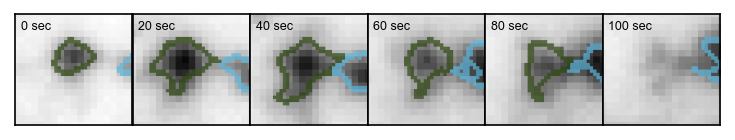

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 6, figsize=(5, 2), dpi=150)
for idx, val in enumerate(range(first_frame, first_frame + 120, 20)):
    ax[idx].imshow(rgb_event[val])
    # remove ticks
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    # Add text to the upper left corner
    ax[idx].text(0.05, 0.95, f'{val*1:.0f} sec', transform=ax[idx].transAxes,
                    fontsize=6, verticalalignment='top', horizontalalignment='left')
    ax[idx].margins(0, 0)

plt.tight_layout(h_pad=0, w_pad=0)

plt.savefig("plots/event_sequence.svg", dpi=600)
plt.show()


## Plot Kymograph

In [ ]:
def project_labels(label_image: np.ndarray, axis: int, y_scale: int =1):
  """
  Projects image along a specified axis.

  Parameters:
    label_image: A NumPy array of shape (t, y, x) representing the label image.
    axis: An integer specifying the axis along which to project (0 for time, 1 for y, 2 for x).
    y_scale: integer how many times the y_axis should be sampled

  Returns:
    A NumPy array of shape (y, t) or (x, t) representing the projected label image.
  """
  if axis >= label_image.ndim:
      raise ValueError("Invalid axis: {}".format(axis))
  projection = label_image.max(axis=axis)
  # projection = np.where(projection == 0, np.nan, projection)
  return np.repeat(projection, y_scale, axis=0)

In [ ]:
viewer = napari.Viewer()
viewer.add_labels(project_labels(filtered_events, 2))
noodles_rbg = render_as_rgb(viewer, upsample_factor=1)
viewer.close()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(noodles_rbg, cmap='tab20', vmin=1, vmax=3, interpolation='none', aspect=0.7)
ax.set_xlabel('X-Axis')
ax.invert_yaxis()

# Get the original y-ticks
original_ticks = ax.get_yticks()

# Assuming 'noodles_rbg' is a 2D array, get the current y-axis limit
y_max = noodles_rbg.shape[0]

# Convert these ticks to minutes and format using f-strings without units
new_tick_labels = [f"{(tick * 3) / 60:.0f}" for tick in original_ticks]  # Multiply by 10 to adjust the scale

# Set the new ticks and labels
# ax.set_yticks(original_ticks)
ax.set_yticklabels(new_tick_labels)

ax.set_ylabel('Time [min]')

plt.tight_layout()
plt.savefig('plots/noodles.svg', dpi=600)

In [ ]:
from skimage import transform
viewer = napari.Viewer()

viewer.add_image(project_labels(lifeact, 2), colormap='gray_r')
l = viewer.add_labels(project_labels(events, 2))
l.contour = 3

noodles_rbg_rGBD = render_as_rgb(viewer, upsample_factor=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(noodles_rbg_rGBD, interpolation='none', aspect=0.7)
# Get the original y-ticks
original_ticks = ax.get_yticks()

# Assuming 'noodles_rbg' is a 2D array, get the current y-axis limit
y_max = noodles_rbg.shape[0]

# Convert these ticks to minutes and format using f-strings without units
new_tick_labels = [f"{(tick * 3) / 60:.0f}" for tick in original_ticks]  # Multiply by 10 to adjust the scale

# Set the new ticks and labels
# ax.set_yticks(original_ticks)
ax.set_yticklabels(new_tick_labels)

ax.set_ylabel('Time [min]')
ax.set_xlabel('X-Axis')
ax.invert_yaxis()
# ax.set_xlim(100, 800)
plt.tight_layout()
plt.savefig('plots/noodles_bg_removed.svg', dpi=600)

In [ ]:
from skimage import transform
viewer = napari.Viewer()

viewer.add_image(project_labels(lifeact, 2), colormap='gray_r')

max_rGBD = render_as_rgb(viewer, upsample_factor=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(max_rGBD, interpolation='none', aspect=0.7)
# Get the original y-ticks
original_ticks = ax.get_yticks()

# Assuming 'noodles_rbg' is a 2D array, get the current y-axis limit
y_max = noodles_rbg.shape[0]

# Convert these ticks to minutes and format using f-strings without units
new_tick_labels = [f"{(tick * 3) / 60:.0f}" for tick in original_ticks]  # Multiply by 10 to adjust the scale

# Set the new ticks and labels
# ax.set_yticks(original_ticks)
ax.set_yticklabels(new_tick_labels)

ax.set_ylabel('Time [min]')
ax.set_xlabel('X-Axis')
ax.invert_yaxis()
# ax.set_xlim(100, 800)
plt.tight_layout()
plt.savefig('plots/raw_max_proj.svg', dpi=600)

In [ ]:
from skimage.measure import regionprops_table
# plot centroid xy projection of the filtered events
all_dfs = []
for idx_pos, pos in enumerate(all_events_filtered):
    for idx, frame in enumerate(pos):
        props = regionprops_table(frame, properties=('label', 'centroid', 'area'))
        df = pd.DataFrame(props)
        df['frame'] = idx
        df['position'] = idx_pos
        all_dfs.append(df)

df = pd.concat(all_dfs)
df['x'] = df['centroid-1']
df['y'] = df['centroid-0']
df = df.drop(columns=['centroid-0', 'centroid-1'])

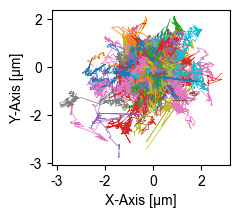

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
for name, group in df.groupby(['label', 'position']):
    # set first from to 0,0
    group['x'] = group['x'] - group['x'].iloc[0]
    group['y'] = group['y'] - group['y'].iloc[0]
    ax.plot(group['x'], group['y'], label=name, lw=0.5)

# convert axis to um
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}".format(x*0.15)))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}".format(x*0.15)))
ax.set_ylabel('Y-Axis [µm]')
ax.set_xlabel('X-Axis [µm]')

ax.set_aspect('equal')


plt.tight_layout()
plt.savefig('plots/centroid_projection.svg', dpi=600)


In [ ]:
df.groupby(['label', 'position'])['frame'].transform('count')

0     153
1      20
2     391
3     151
4      14
     ... 
23      8
24     10
25      7
26      9
27      6
Name: frame, Length: 35216, dtype: int64

In [ ]:
df.frame.max()

395

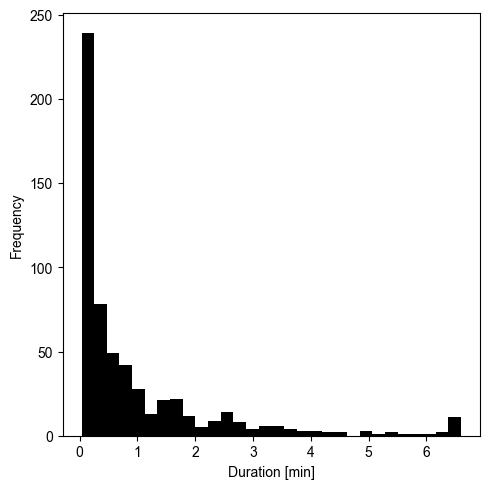

In [ ]:
# filter out tracks of small area
# df = df[df.groupby('label')['area'].transform('mean') > 5]




# plot histogram of the track duration
duration = df.groupby(['label', 'position'])['frame'].count() * 1 / 60
# log scale
# duration = np.log10(duration)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist(duration, bins=30, color='black')
ax.set_xlabel('Duration [min]')
ax.set_ylabel('Frequency')
# set x-axis to log scale
# ax.set_yscale('log')
# ax.set_xscale('log')


plt.tight_layout()
plt.savefig('plots/track_duration.svg', dpi=600)

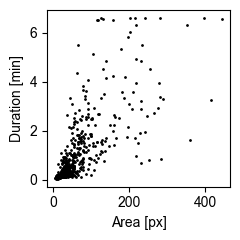

In [ ]:
# plot duration vs area
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.scatter(df.groupby(['label', 'position'])['area'].max(), duration, color='black', s=1)
ax.set_xlabel('Area [px]')
ax.set_ylabel('Duration [min]')
plt.tight_layout()
plt.savefig('plots/track_duration_vs_area.svg', dpi=600)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(all_raw[2], name='lifeact', colormap='gray_r', blending='additive', contrast_limits=[100, 2000])
# viewer.add_labels(np.asanyarray(filtered_events), name='filtered_events')
viewer.add_tracks(df.query('position==2')[['label','frame', 'y', 'x']].to_numpy(), name='tracks')

for layer in viewer.layers:
    layer.scale = (1,0.15, 0.15)

viewer.scale_bar.unit = 'um'
viewer.scale_bar.color = 'black'
viewer.scale_bar.visible = True

In [ ]:
lifeact.shape[-2] * 4, lifeact.shape[-1] * 4


In [ ]:
rgb_stack = render_as_rgb(viewer, axis=0, upsample_factor=10)

In [ ]:
io.imshow(rgb_stack[0])

In [ ]:
from pathlib import Path

In [ ]:
save_image_stack(rgb_stack, name='out.mp4', output_type='mp4', fps=30)

In [ ]:
rgb_stack.shape

In [ ]:
Path('plots/rgb_stack.mp4')